<a href="https://colab.research.google.com/github/hellocybernetics/TensorFlow_Eager_Execution_Tutorials/blob/master/tutorials/99_others/hyper_parameter_optimization_using_optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna
!pip install tf-nightly-2.0-preview

    100% |████████████████████████████████| 61kB 5.5MB/s 
    100% |████████████████████████████████| 81kB 13.8MB/s 
    100% |████████████████████████████████| 51kB 24.2MB/s 
    100% |████████████████████████████████| 92kB 23.9MB/s 
    100% |████████████████████████████████| 112kB 33.5MB/s 
  Running setup.py bdist_wheel for optuna ... - \ done
  Stored in directory: /root/.cache/pip/wheels/6b/35/b5/c8dda18e03a24da1fb839ccf5ec7ddda34469ab7cb5f4ff831
  Running setup.py bdist_wheel for pyperclip ... - done
  Stored in directory: /root/.cache/pip/wheels/92/f0/ac/2ba2972034e98971c3654ece337ac61e546bdeb34ca960dc8c
Successfully built optuna pyperclip
  [typing]
You must restart the runtime in order to use newly installed versions.
    100% |████████████████████████████████| 75.0MB 423kB/s 
    100% |████████████████████████████████| 3.2MB 10.1MB/s 
    100% |████████████████████████████████| 61kB 20.8MB/s 
    100% |████████████████████████████████| 245kB 16.3MB/s 
    100% |███████

In [2]:
import numpy as np
import tensorflow as tf
import optuna
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Simple Practice
### objective function

$$
f(x) = 2x^4 - 5x^2 + x
$$

We will find the minimum value of $f(x^*)$ and $x^*$ using optuna which is provided Prefferd Networks.

### graph of $f(x)$

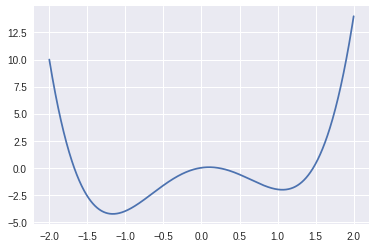

In [3]:
x = np.linspace(-2, 2, 1000)
plt.plot(x, 2*x**4 - 5*x**2 + x)

### optimization
We will minimize $f(x)$ where $x \in [-2, 2]$.

In [0]:
def objective(trial):
    x = trial.suggest_uniform('x', -2, 2)
    return 2*x**4 - 5*x**2 + x

In [5]:
study = optuna.create_study()
study.optimize(objective, n_trials=30)

[I 2019-01-16 11:56:08,652] Finished a trial resulted in value: -0.14883524366617035. Current best value is -0.14883524366617035 with parameters: {'x': 0.3082780234526088}.
[I 2019-01-16 11:56:08,656] Finished a trial resulted in value: -2.003942800211039. Current best value is -2.003942800211039 with parameters: {'x': 1.0040586437270083}.
[I 2019-01-16 11:56:08,661] Finished a trial resulted in value: -1.2372743017197956. Current best value is -2.003942800211039 with parameters: {'x': 1.0040586437270083}.
[I 2019-01-16 11:56:08,665] Finished a trial resulted in value: 0.6234074742607496. Current best value is -2.003942800211039 with parameters: {'x': 1.0040586437270083}.
[I 2019-01-16 11:56:08,669] Finished a trial resulted in value: 2.173214593940769. Current best value is -2.003942800211039 with parameters: {'x': 1.0040586437270083}.
[I 2019-01-16 11:56:08,673] Finished a trial resulted in value: -0.1639477716829485. Current best value is -2.003942800211039 with parameters: {'x': 1.

### result

minimum f(x) :  -4.162215448144136
argmin f(x) :  {'x': -1.0645092747749707}


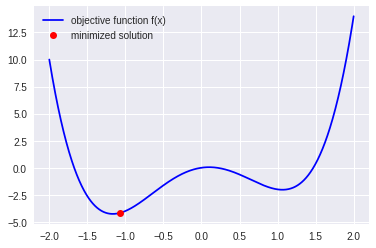

In [6]:
print("minimum f(x) : ", study.best_value)
print("argmin f(x) : ", study.best_params)

plt.plot(x, 2*x**4 - 5*x**2 + x, "b")
plt.plot(study.best_params['x'], study.best_value, "ro")
plt.legend(["objective function f(x)", "minimized solution"])

## optuna for TensorFlow Eager

### Create model
In this section, create_model funtion have an arg `trial` which is represente search spaces of 'num of layers' and 'dropout_rate'.  

In [0]:
def create_model(trial):
    # num of hidden layer
    n_layers = trial.suggest_int('n_layers', 1, 3)
    
    # dropout_rate
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    
    layers = []
    for i in range(n_layers):
        layers.append(
            tf.keras.layers.Conv2D(filters=(i+1)*16, 
                                   kernel_size=3, 
                                   padding="same",
                                   activation="relu")
        )
        layers.append(
            tf.keras.layers.MaxPool2D(pool_size=2, padding="same")
        )
        layers.append(
            tf.keras.layers.Dropout(rate=dropout_rate)
        )
    
    layers.append(tf.keras.layers.Flatten())
    layers.append(tf.keras.layers.Dense(128, activation="relu"))
    layers.append(tf.keras.layers.Dense(10, activation="softmax"))
    
    return tf.keras.Sequential(layers)
    

### create optimizer
Then, we create optimzier.

In [0]:
def create_optimizer(trial):
    # Loguniform parameter
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    return optimizer

### create trainer
In this section we will create trainer which is simply training loop. We will use keras training API. 

In [0]:
def trainer(trial, x_train, y_train):
    
    batch_size=trial.suggest_categorical('batch_size', [256, 512, 1024])
    
    model = create_model(trial)
    optimizer = create_optimizer(trial)
    
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=["accuracy"])

    model.fit(x=x_train,
              y=y_train,
              batch_size=batch_size,
              epochs=5,
              )
    
    model.fit = tf.function(model.fit)

    return model

#### objective
We create objective function. Note that optuna minimize objective function, so when we create objective function, this is defined "better equal to smaller". Therefore, we define objective function "`1 - accuracy`".

In [0]:
def objective(trial):
    
    (x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0
    x_train = x_train.reshape(-1, 28, 28, 1)
    x_test = x_test.reshape(-1, 28, 28, 1)

    x_train_ = tf.convert_to_tensor(x_train, dtype=tf.float32)
    y_train_ = tf.reshape(tf.one_hot(y_train, 10), (-1, 10))
    x_test_ = tf.convert_to_tensor(x_test, dtype=tf.float32)
    y_test_ = tf.reshape(tf.one_hot(y_test, 10), (-1, 10))


    model = trainer(trial, x_train_, y_train_)
    
    evaluate = model.evaluate(x=x_test_, y=y_test_)
    return 1 - evaluate[1]

In [15]:
study = optuna.create_study()
study.optimize(objective, n_trials=10)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/5
60000/60000==============================] - 50s 834us/sample - loss: 0.5458 - acc: 0.8430
Epoch 2/5
60000/60000==============================] - 50s 836us/sample - loss: 0.1134 - acc: 0.9650
Epoch 3/5
60000/60000==============================] - 50s 838us/sample - loss: 0.0834 - acc: 0.9738
Epoch 4/5
60000/60000==============================] - 51s 848us/sample - loss: 0.0667 - acc: 0.9787
Epoch 5/5
60000/60000==============================] - 51s 849us/sample - loss: 0.0568 - acc: 0.9819
10000/10000==============================] - 3s 334us/sample - loss: 0.0536 - acc: 0.9818


[I 2019-01-16 12:03:12,759] Finished a trial resulted in value: 0.01819998025894165. Current best value is 0.01819998025894165 with parameters: {'batch_size': 256, 'n_layers': 3, 'dropout_rate': 0.006591096488057002, 'learning_rate': 0.00045737147080074294}.


Epoch 1/5
60000/60000==============================] - 49s 824us/sample - loss: 1.3140 - acc: 0.6370
Epoch 2/5
60000/60000==============================] - 49s 815us/sample - loss: 0.3432 - acc: 0.8947
Epoch 3/5
60000/60000==============================] - 49s 813us/sample - loss: 0.2025 - acc: 0.9380
Epoch 4/5
60000/60000==============================] - 49s 818us/sample - loss: 0.1491 - acc: 0.9541
Epoch 5/5
60000/60000==============================] - 49s 823us/sample - loss: 0.1230 - acc: 0.9617
10000/10000==============================] - 3s 332us/sample - loss: 0.0811 - acc: 0.9743


[I 2019-01-16 12:07:23,213] Finished a trial resulted in value: 0.025699973106384277. Current best value is 0.01819998025894165 with parameters: {'batch_size': 256, 'n_layers': 3, 'dropout_rate': 0.006591096488057002, 'learning_rate': 0.00045737147080074294}.


Epoch 1/5
60000/60000==============================] - 40s 661us/sample - loss: 0.6354 - acc: 0.7993
Epoch 2/5
60000/60000==============================] - 39s 656us/sample - loss: 0.2080 - acc: 0.9347
Epoch 3/5
60000/60000==============================] - 42s 698us/sample - loss: 0.1434 - acc: 0.9555
Epoch 4/5
60000/60000==============================] - 39s 654us/sample - loss: 0.1128 - acc: 0.9643
Epoch 5/5
60000/60000==============================] - 39s 658us/sample - loss: 0.0967 - acc: 0.9694
10000/10000==============================] - 3s 340us/sample - loss: 0.0456 - acc: 0.9846


[I 2019-01-16 12:10:47,906] Finished a trial resulted in value: 0.0153999924659729. Current best value is 0.0153999924659729 with parameters: {'batch_size': 1024, 'n_layers': 2, 'dropout_rate': 0.42479464527391053, 'learning_rate': 0.0027350144484027446}.


Epoch 1/5
60000/60000==============================] - 41s 678us/sample - loss: 0.6207 - acc: 0.8307
Epoch 2/5
60000/60000==============================] - 41s 675us/sample - loss: 0.1595 - acc: 0.9529
Epoch 3/5
60000/60000==============================] - 41s 681us/sample - loss: 0.1058 - acc: 0.9686
Epoch 4/5
60000/60000==============================] - 40s 674us/sample - loss: 0.0818 - acc: 0.9750
Epoch 5/5
60000/60000==============================] - 40s 673us/sample - loss: 0.0706 - acc: 0.9781
10000/10000==============================] - 3s 339us/sample - loss: 0.0463 - acc: 0.9852


[I 2019-01-16 12:14:15,715] Finished a trial resulted in value: 0.014800012111663818. Current best value is 0.014800012111663818 with parameters: {'batch_size': 512, 'n_layers': 2, 'dropout_rate': 0.11331028508755175, 'learning_rate': 0.0007330875419572042}.


Epoch 1/5
60000/60000==============================] - 50s 835us/sample - loss: 2.2230 - acc: 0.2438
Epoch 2/5
60000/60000==============================] - 50s 837us/sample - loss: 1.6565 - acc: 0.5076
Epoch 3/5
60000/60000==============================] - 50s 839us/sample - loss: 1.0372 - acc: 0.6585
Epoch 4/5
60000/60000==============================] - 50s 838us/sample - loss: 0.7926 - acc: 0.7391
Epoch 5/5
60000/60000==============================] - 50s 836us/sample - loss: 0.6567 - acc: 0.7850
10000/10000==============================] - 4s 391us/sample - loss: 0.4264 - acc: 0.8920


[I 2019-01-16 12:18:32,736] Finished a trial resulted in value: 0.10799998044967651. Current best value is 0.014800012111663818 with parameters: {'batch_size': 512, 'n_layers': 2, 'dropout_rate': 0.11331028508755175, 'learning_rate': 0.0007330875419572042}.


Epoch 1/5
60000/60000==============================] - 41s 682us/sample - loss: 0.5197 - acc: 0.8584
Epoch 2/5
60000/60000==============================] - 41s 680us/sample - loss: 0.1126 - acc: 0.9662
Epoch 3/5
60000/60000==============================] - 41s 678us/sample - loss: 0.0791 - acc: 0.9765
Epoch 4/5
60000/60000==============================] - 40s 673us/sample - loss: 0.0637 - acc: 0.9804
Epoch 5/5
60000/60000==============================] - 41s 675us/sample - loss: 0.0530 - acc: 0.9842
10000/10000==============================] - 3s 347us/sample - loss: 0.0399 - acc: 0.9857


[I 2019-01-16 12:22:01,167] Finished a trial resulted in value: 0.014299988746643066. Current best value is 0.014299988746643066 with parameters: {'batch_size': 512, 'n_layers': 2, 'dropout_rate': 0.11377378497161844, 'learning_rate': 0.0012499916746416}.


Epoch 1/5
60000/60000==============================] - 41s 681us/sample - loss: 2.2422 - acc: 0.2870
Epoch 2/5
60000/60000==============================] - 41s 675us/sample - loss: 2.0348 - acc: 0.5860
Epoch 3/5
60000/60000==============================] - 40s 675us/sample - loss: 1.6789 - acc: 0.7165
Epoch 4/5
60000/60000==============================] - 40s 673us/sample - loss: 1.2620 - acc: 0.7590
Epoch 5/5
60000/60000==============================] - 40s 672us/sample - loss: 0.9332 - acc: 0.7896
10000/10000==============================] - 4s 356us/sample - loss: 0.7862 - acc: 0.8358


[I 2019-01-16 12:25:28,965] Finished a trial resulted in value: 0.16420000791549683. Current best value is 0.014299988746643066 with parameters: {'batch_size': 512, 'n_layers': 2, 'dropout_rate': 0.11377378497161844, 'learning_rate': 0.0012499916746416}.


Epoch 1/5
60000/60000==============================] - 24s 395us/sample - loss: 0.3106 - acc: 0.9075
Epoch 2/5
60000/60000==============================] - 23s 389us/sample - loss: 0.1025 - acc: 0.9690
Epoch 3/5
60000/60000==============================] - 23s 389us/sample - loss: 0.0740 - acc: 0.9771
Epoch 4/5
60000/60000==============================] - 23s 387us/sample - loss: 0.0611 - acc: 0.9804
Epoch 5/5
60000/60000==============================] - 23s 386us/sample - loss: 0.0481 - acc: 0.9848
10000/10000==============================] - 3s 274us/sample - loss: 0.0442 - acc: 0.9852


[I 2019-01-16 12:27:29,928] Finished a trial resulted in value: 0.014800012111663818. Current best value is 0.014299988746643066 with parameters: {'batch_size': 512, 'n_layers': 2, 'dropout_rate': 0.11377378497161844, 'learning_rate': 0.0012499916746416}.


Epoch 1/5
60000/60000==============================] - 50s 837us/sample - loss: 1.1997 - acc: 0.6205
Epoch 2/5
60000/60000==============================] - 50s 826us/sample - loss: 0.3459 - acc: 0.8951
Epoch 3/5
60000/60000==============================] - 50s 829us/sample - loss: 0.2135 - acc: 0.9346
Epoch 4/5
60000/60000==============================] - 50s 829us/sample - loss: 0.1586 - acc: 0.9522
Epoch 5/5
60000/60000==============================] - 49s 822us/sample - loss: 0.1324 - acc: 0.9593
10000/10000==============================] - 4s 413us/sample - loss: 0.0739 - acc: 0.9784


[I 2019-01-16 12:31:44,970] Finished a trial resulted in value: 0.021600008010864258. Current best value is 0.014299988746643066 with parameters: {'batch_size': 512, 'n_layers': 2, 'dropout_rate': 0.11377378497161844, 'learning_rate': 0.0012499916746416}.


Epoch 1/5
60000/60000==============================] - 24s 393us/sample - loss: 0.2888 - acc: 0.9177
Epoch 2/5
60000/60000==============================] - 23s 388us/sample - loss: 0.0849 - acc: 0.9751
Epoch 3/5
60000/60000==============================] - 24s 393us/sample - loss: 0.0580 - acc: 0.9827
Epoch 4/5
60000/60000==============================] - 23s 389us/sample - loss: 0.0450 - acc: 0.9860
Epoch 5/5
60000/60000==============================] - 23s 386us/sample - loss: 0.0344 - acc: 0.9897
10000/10000==============================] - 3s 272us/sample - loss: 0.0503 - acc: 0.9831


[I 2019-01-16 12:33:46,218] Finished a trial resulted in value: 0.01690000295639038. Current best value is 0.014299988746643066 with parameters: {'batch_size': 512, 'n_layers': 2, 'dropout_rate': 0.11377378497161844, 'learning_rate': 0.0012499916746416}.


In [16]:
study.trials

[FrozenTrial(trial_id=0, state=<TrialState.COMPLETE: 1>, value=0.01819998025894165, datetime_start=datetime.datetime(2019, 1, 16, 11, 58, 55, 371526), datetime_complete=datetime.datetime(2019, 1, 16, 12, 3, 12, 758762), params={'batch_size': 256, 'n_layers': 3, 'dropout_rate': 0.006591096488057002, 'learning_rate': 0.00045737147080074294}, user_attrs={}, system_attrs={}, intermediate_values={}, params_in_internal_repr={'batch_size': 0, 'n_layers': 3, 'dropout_rate': 0.006591096488057002, 'learning_rate': 0.00045737147080074294}),
 FrozenTrial(trial_id=1, state=<TrialState.COMPLETE: 1>, value=0.025699973106384277, datetime_start=datetime.datetime(2019, 1, 16, 12, 3, 12, 763549), datetime_complete=datetime.datetime(2019, 1, 16, 12, 7, 23, 213201), params={'batch_size': 1024, 'n_layers': 3, 'dropout_rate': 0.06535245800568545, 'learning_rate': 0.00045751486913622914}, user_attrs={}, system_attrs={}, intermediate_values={}, params_in_internal_repr={'batch_size': 2, 'n_layers': 3, 'dropout_

In [17]:
print("best params: ", study.best_params)
print("best test accuracy: ", 1 - study.best_value)

best params:  {'batch_size': 512, 'n_layers': 2, 'dropout_rate': 0.11377378497161844, 'learning_rate': 0.0012499916746416}
best test accuracy:  0.9857000112533569
